## Packages

In [ ]:
!git clone https://github.com/OSUPCVLab/SegFormer3D.git
%cd SegFormer3D

!pip install -r requirements.txt
!pip install monai accelerate termcolor

In [5]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from monai.transforms import Transform, MapTransform

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Adjust SegFormer3D package to handle BraTs 2023 data

In [7]:
!mkdir -p /content/SegFormer3D/data/brats2023_seg/BraTS2023_Processed_Data
!mkdir -p /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data
!mkdir -p /content/SegFormer3D/experiments/brats_2023/my_experiment

In [13]:
%%writefile /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py
import os
import torch
import nibabel
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation
from monai.data import MetaTensor
from multiprocessing import Process, Pool
from sklearn.preprocessing import MinMaxScaler
from monai.transforms import (
    Orientation,
    EnsureType,
    Transform,
    MapTransform
)
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor


class ConvertToMultiChannelBasedOnBrats2023Classes(Transform):
    """
    Convert labels to multi channels based on BraTS 2023 classes:
    label 1 is the Nonenhancing Tumor Core (NETC)
    label 2 is the Surrounding Non-Enhancing FLAIR Hyperintensity (SNFH)
    label 3 is the Enhancing Tumor (ET)
    """

    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __call__(self, img):
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)

        result = [
            (img == 1),  # NETC
            (img == 2),  # SNFH
            (img == 3)   # ET
        ]
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)


class Brats2023Preprocess:
    def __init__(
        self,
        train_folder_dir: str = "/content/drive/MyDrive/BraTs/brats2023-training",
        save_dir: str = "/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data",
    ):
        """
        train_folder_name: name of the folder of the training data
        save_dir: path to directory where each case is going to be saved as a single file containing four modalities
        """
        self.save_dir = save_dir
        self.train_folder_dir = train_folder_dir
        assert os.path.exists(self.train_folder_dir)

        # walking through the raw training data and list all the folder names, i.e. case name
        self.case_name = next(os.walk(self.train_folder_dir), (None, None, []))[1]
        assert len(self.case_name) > 0, "No cases found in the directory!"
        # MRI type
        self.MRI_TYPE = ["t1n", "t1c", "t2f", "t2w", "seg"]

    def __len__(self):
        return self.case_name.__len__()

    def get_modality_fp(self, case_name: str, mri_type: str)->str:
        """
        return the modality file path
        case_name: patient ID
        mri_type: any of the ["t1n", "t1c", "t2f", "t2w", "seg"]
        """
        modality_fp = os.path.join(
            self.train_folder_dir,
            case_name,
            case_name + f"-{mri_type}.nii",
        )
        return modality_fp

    def load_nifti(self, fp)->list:
        """
        load a nifti file
        fp: path to the nifti file with (nii or nii.gz) extension
        """
        nifti_data = nibabel.load(fp)
        # get the floating point array
        nifti_scan = nifti_data.get_fdata()
        # get affine matrix
        affine = nifti_data.affine
        return nifti_scan, affine

    def normalize(self, x:np.ndarray)->np.ndarray:
        # Transform features by scaling each feature to a given range.
        scaler = MinMaxScaler(feature_range=(0, 1))
        # (H, W, D) -> (H * W, D)
        normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
        normalized_data = normalized_1D_array.reshape(x.shape)
        return normalized_data

    def orient(self, x: MetaTensor) -> MetaTensor:
        # orient the array to be in (Right, Anterior, Superior) scanner coordinate systems
        assert type(x) == MetaTensor
        return Orientation(axcodes="RAS")(x)

    def detach_meta(self, x: MetaTensor) -> np.ndarray:
        assert type(x) == MetaTensor
        return EnsureType(data_type="numpy", track_meta=False)(x)

    def crop_zero_pixels(self, x: np.ndarray)->np.ndarray:
        # get rid of the zero pixels around mri scan and cut it so that the region is useful
        # crop (1, 240, 240, 155) to (1, 128, 128, 128)
        return x[:, 56:184, 56:184, 13:141]

    def preprocess_brats_modality(self, data_fp: str, is_label: bool = False)->np.ndarray:
        """
        apply preprocess stage to the modality
        data_fp: directory to the modality
        """
        data, affine = self.load_nifti(data_fp)
        # label do not the be normalized
        if is_label:
            # Binary mask does not need to be float64! For saving storage purposes!
            data = data.astype(np.uint8)
            # categorical -> one-hot-encoded
            # (240, 240, 155) -> (3, 240, 240, 155)
            data = ConvertToMultiChannelBasedOnBrats2023Classes()(data)
        else:
            data = self.normalize(x=data)
            # (240, 240, 155) -> (1, 240, 240, 155)
            data = data[np.newaxis, ...]

        data = MetaTensor(x=data, affine=affine)
        # for oreinting the coordinate system we need the affine matrix
        data = self.orient(data)
        # detaching the meta values from the oriented array
        data = self.detach_meta(data)
        # (240, 240, 155) -> (128, 128, 128)
        data = self.crop_zero_pixels(data)
        return data

    def __getitem__(self, idx):
        case_name = self.case_name[idx]

        # preprocess t1n modality
        T1N = self.get_modality_fp(case_name, self.MRI_TYPE[0])
        t1n = self.preprocess_brats_modality(data_fp=T1N, is_label=False)
        t1n_transv = t1n.swapaxes(1, 3) # transverse plane

        # preprocess t1c modality
        T1C = self.get_modality_fp(case_name, self.MRI_TYPE[1])
        t1c = self.preprocess_brats_modality(data_fp=T1C, is_label=False)
        t1c_transv = t1c.swapaxes(1, 3) # transverse plane

        # preprocess t2f modality
        T2F = self.get_modality_fp(case_name, self.MRI_TYPE[2])
        t2f = self.preprocess_brats_modality(data_fp=T2F, is_label=False)
        t2f_transv = t2f.swapaxes(1, 3) # transverse plane

        # preprocess t2w modality
        T2W = self.get_modality_fp(case_name, self.MRI_TYPE[3])
        t2w = self.preprocess_brats_modality(data_fp=T2W, is_label=False)
        t2w_transv = t2w.swapaxes(1, 3) # transverse plane

        # preprocess segmentation label
        Label = self.get_modality_fp(case_name, self.MRI_TYPE[4])
        label = self.preprocess_brats_modality(data_fp=Label, is_label=True)
        label_transv = label.swapaxes(1, 3) # transverse plane

        # stack modalities along the first dimension
        modalities = np.concatenate(
            (t1n_transv, t1c_transv, t2f_transv, t2w_transv),
            axis=0,
        )
        label = label_transv
        return modalities, label, case_name

    def __call__(self):
        print("started preprocessing brats2023...")
        with Pool(processes=os.cpu_count()) as multi_p:
            multi_p.map_async(func=self.process, iterable=range(self.__len__()))
            multi_p.close()
            multi_p.join()
        print("finished preprocessing brats2023...")

    def process(self, idx):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        # get the 4D modalities along with the label
        modalities, label, case_name = self.__getitem__(idx)
        # creating the folder for the current case id
        data_save_path = os.path.join(self.save_dir, case_name)
        if not os.path.exists(data_save_path):
            os.makedirs(data_save_path)
        # saving the preprocessed 4D modalities containing all the modalities to save path
        modalities_fn = data_save_path + f"/{case_name}_modalities.pt"
        torch.save(modalities, modalities_fn)
        # saving the preprocessed segmentation label to save path
        label_fn = data_save_path + f"/{case_name}_label.pt"
        torch.save(label, label_fn)


if __name__ == "__main__":
    preprocessor = Brats2023Preprocess()
    # start preprocessing
    preprocessor()

Overwriting /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py


In [9]:
%%writefile /content/SegFormer3D/dataloaders/brats2023_seg.py
import os
import torch
import pandas as pd
from torch.utils.data import Dataset

class Brats2023Dataset(Dataset):
    def __init__(self, root_dir, is_train=True, transform=None, fold_id=None):
        super().__init__()
        csv_name = "train.csv" if is_train else "validation.csv"
        csv_fp = os.path.join(root_dir, csv_name)
        assert os.path.exists(csv_fp), f"CSV file not found: {csv_fp}"

        self.csv = pd.read_csv(csv_fp)
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        data_path = self.csv["data_path"][idx]
        case_name = self.csv["case_name"][idx]

        volume_fp = os.path.join(data_path, f"{case_name}_modalities.pt")
        label_fp = os.path.join(data_path, f"{case_name}_label.pt")

        volume = torch.tensor(torch.load(volume_fp)).float()
        label = torch.tensor(torch.load(label_fp)).float()

        data = {"image": volume, "label": label}

        if self.transform:
            data = self.transform(data)

        return data

Writing /content/SegFormer3D/dataloaders/brats2023_seg.py


In [10]:
%%writefile /content/SegFormer3D/dataloaders/build_dataset.py
import sys
from typing import Dict
from monai.data import DataLoader
from augmentations.augmentations import build_augmentations

def build_dataset(dataset_type: str, dataset_args: Dict):
    if dataset_type == "brats2023_seg":
        from .brats2023_seg import Brats2023Dataset
        dataset = Brats2023Dataset(
            root_dir=dataset_args["root"],
            is_train=dataset_args["train"],
            transform=build_augmentations(dataset_args["train"]),
            fold_id=dataset_args["fold_id"],
        )
        return dataset
    else:
        raise ValueError("only brats2023 segmentation is currently supported!")

def build_dataloader(dataset, dataloader_args: Dict, config: Dict = None, train: bool = True) -> DataLoader:
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader_args["batch_size"],
        shuffle=dataloader_args["shuffle"],
        num_workers=dataloader_args["num_workers"],
        drop_last=dataloader_args["drop_last"],
        pin_memory=True,
    )
    return dataloader

Overwriting /content/SegFormer3D/dataloaders/build_dataset.py


In [11]:
%%writefile /content/SegFormer3D/experiments/brats_2023/my_experiment/config.yaml
# wandb parameters
project: segfmr3d
wandb_parameters:
  mode: "offline" # set this to "online" if you want to log to wandb
  entity: pcvlab
  group: brats2023
  name: segformer3d_adamw_batch2_diceloss
  resume: False
  tags: ["pcvlab", "dice", "b0_model", "adamw"]

# model parameters
model_name: segformer3d
model_parameters:
  in_channels: 4
  sr_ratios: [4, 2, 1, 1]
  embed_dims: [32, 64, 160, 256]
  patch_kernel_size: [7, 3, 3, 3]
  patch_stride: [4, 2, 2, 2]
  patch_padding: [3, 1, 1, 1]
  mlp_ratios: [4, 4, 4, 4]
  num_heads: [1, 2, 5, 8]
  depths: [2, 2, 2, 2]
  num_classes: 3
  decoder_dropout: 0.0
  decoder_head_embedding_dim: 256

# loss function
loss_fn:
  loss_type: "dice"
  loss_args: None

# optimizer
optimizer:
  optimizer_type: "adamw"
  optimizer_args:
    lr: 0.0001
    weight_decay: 0.01

# schedulers
warmup_scheduler:
  enabled: True # should be always true
  warmup_epochs: 20

train_scheduler:
  scheduler_type: 'cosine_annealing_wr'
  scheduler_args:
    t_0_epochs: 400
    t_mult: 1
    min_lr: 0.000006

# (Not fully implemented yet) exponential moving average
ema:
  enabled: False
  ema_decay: 0.999
  val_ema_every: 1

sliding_window_inference:
  sw_batch_size: 4
  roi: [128, 128, 128]

# gradient clipping (not implemented yet)
clip_gradients:
  enabled: False
  clip_gradients_value: 0.1

# training hyperparameters
training_parameters:
  seed: 42
  num_epochs: 800
  cutoff_epoch: 400
  load_optimizer: False
  print_every: 200
  calculate_metrics: True
  grad_accumulate_steps: 4 # default: 1
  checkpoint_save_dir: "model_checkpoints/best_dice_checkpoint"
  load_checkpoint: # not implemented yet
    load_full_checkpoint: False
    load_model_only: False
    load_checkpoint_path: None

# dataset args
dataset_parameters:
  dataset_type: "brats2023_seg"
  train_dataset_args:
    root: "../../../data/brats2023_seg"
    train: True
    fold_id: null

  val_dataset_args:
    root: "../../../data/brats2023_seg"
    train: False
    fold_id: null

  train_dataloader_args:
    batch_size: 4
    shuffle: True
    num_workers: 8
    drop_last: True

  val_dataloader_args:
    batch_size: 2
    shuffle: False
    num_workers: 6
    drop_last: False

Writing /content/SegFormer3D/experiments/brats_2023/my_experiment/config.yaml


## Data preparation

### Pre-process data

In [14]:
!python /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py

2024-07-09 17:30:46.914711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 17:30:46.914762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 17:30:46.916226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 17:30:47.923529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
started preprocessing brats2023...
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadloc

### Check preprocessed data

In [31]:
# Load a sample preprocessed file
patient_id = "BraTS-MET-00288-000"
sample_modalities_path = f"/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data/{patient_id}/{patient_id}_modalities.pt"
sample_label_path = f"/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data/{patient_id}/{patient_id}_label.pt"

modalities = torch.load(sample_modalities_path)
label = torch.load(sample_label_path)

print("Shape of modalities tensor:", modalities.shape)
print("Shape of label tensor:", label.shape)

# Convert the label to a PyTorch tensor if it's not already one
if not isinstance(label, torch.Tensor):
    label = torch.tensor(label)

print("Unique classes in label tensor:", torch.unique(label))

Shape of modalities tensor: (4, 128, 128, 128)
Shape of label tensor: (3, 128, 128, 128)
Unique classes in label tensor: tensor([False,  True])


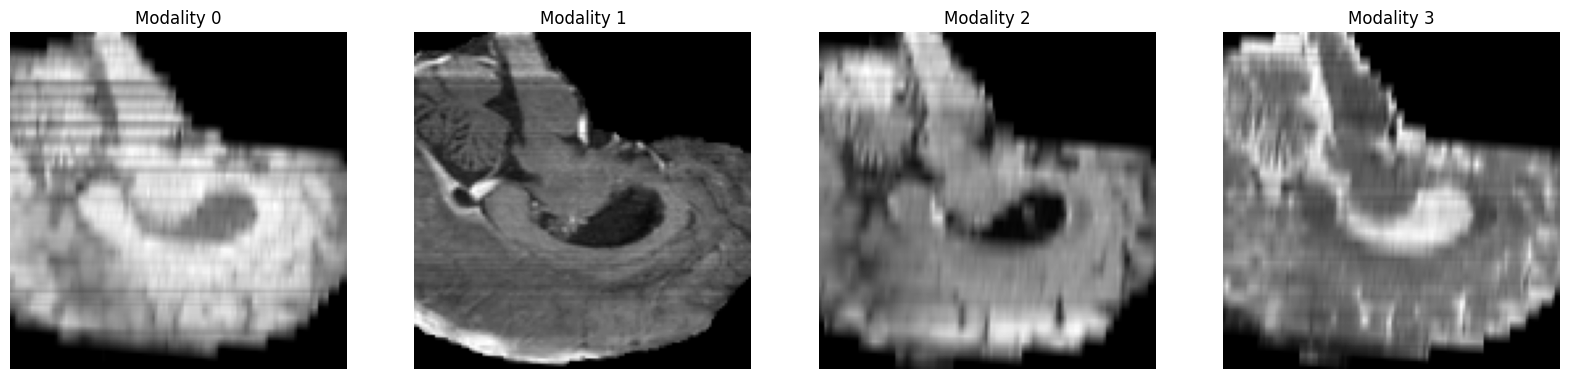

In [35]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(modalities[i, :, :, 64], cmap='gray')
    axes[i].set_title(f'Modality {i}')
    axes[i].axis('off')
plt.show()

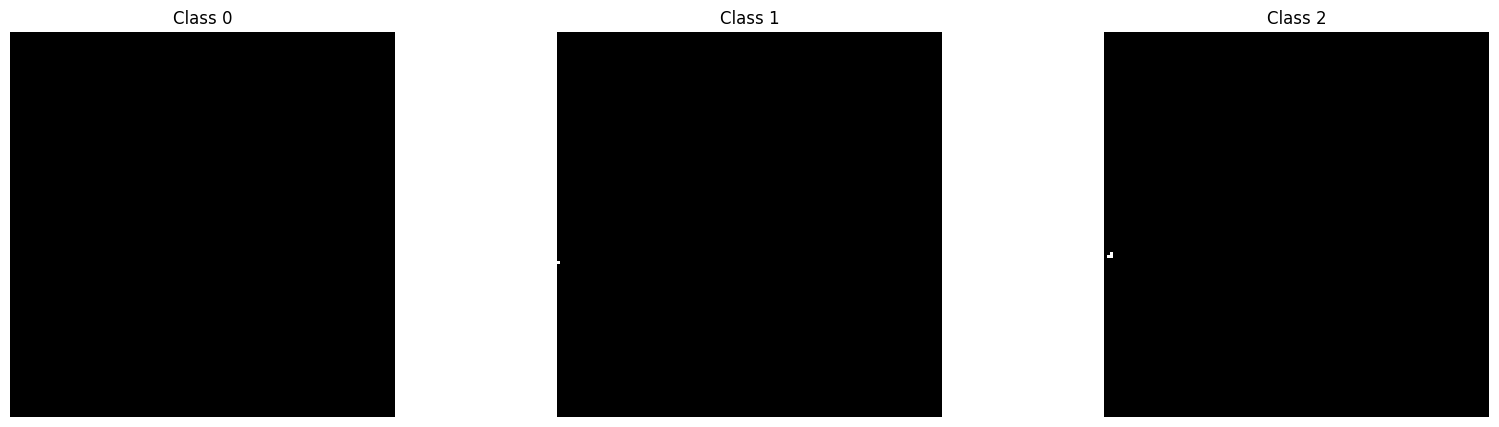

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i in range(3):
    axes[i].imshow(label[i, :, :, 64].numpy(), cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')
plt.show()

### Train-test-split

In [36]:
# Path to the processed data directory
processed_data_dir = '/content/drive/MyDrive/BraTs/BraTS2023_Processed_Data'

# Assume each folder in the processed data directory represents a case
cases = [d for d in os.listdir(processed_data_dir) if os.path.isdir(os.path.join(processed_data_dir, d))]

# Split cases into train and validation (e.g., 80-20 split)
train_cases = cases[:int(len(cases) * 0.8)]
val_cases = cases[int(len(cases) * 0.8):]

# Create DataFrames
train_df = pd.DataFrame({'data_path': [os.path.join(processed_data_dir, c) for c in train_cases], 'case_name': train_cases})
val_df = pd.DataFrame({'data_path': [os.path.join(processed_data_dir, c) for c in val_cases], 'case_name': val_cases})

# Save to CSV
train_df.to_csv('/content/SegFormer3D/data/brats2023_seg/train.csv', index=False)
val_df.to_csv('/content/SegFormer3D/data/brats2023_seg/validation.csv', index=False)

## Training

In [ ]:
!pip install safetensors>=0.4.1
!pip install transformers -U

In [39]:
%cd /content/SegFormer3D/experiments/brats_2023/my_experiment/
!accelerate launch --config_file ./gpu_accelerate.yaml run_experiment.py

/content/SegFormer3D/experiments/brats_2023/my_experiment
2024-07-09 17:59:16.048947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 17:59:16.049004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 17:59:16.050525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 17:59:17.078639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Tracking run with wandb version 0.15.12
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


## Evaluation

## Visualizing results